In [1]:
import sys
import os

parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from features.get_merged_dataframes import get_merged_dataframes

In [2]:
pair_1, pair_2 = "BTC_USDT", "DOT_USDT"

In [3]:
train_df, val_df, test_df = get_merged_dataframes(pair_1, pair_2)

start: 2020-08-18 23:00:00+00:00, end: 2025-04-09 17:54:00+00:00


In [4]:
df = train_df.copy()
df['target'] = 10000 * (df['close_y'].shift(-1) / df['close_y'] - 1)
df = df.iloc[:-1]

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras import Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [6]:
feature_cols = df.columns.drop(['date', 'target']).to_list()
target_col = 'target'

X = df[feature_cols].values
y = df[target_col].values

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

X_lstm = []
y_lstm = []
for i in range(len(X_scaled)):
    X_lstm.append(X_scaled[i])
    y_lstm.append(y_scaled[i])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

X_train, X_valid, y_train, y_valid = train_test_split(X_lstm, y_lstm, test_size=0.2, shuffle=False)

In [10]:
X_lstm.shape

(985897, 130)

In [13]:
model = Sequential([
    Input(shape=(1, 1)),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=1, batch_size=256, validation_data=(X_valid, y_valid))

y_pred = model.predict(X_valid)
y_pred = scaler_y.inverse_transform(y_pred)

rmse = np.mean((y_pred - scaler_y.inverse_transform(y_valid))**2)**0.5
print(f'RMSE: {rmse}')

3081/3081 ━━━━━━━━━━━━━━━━━━━━ 715s 232ms/step - loss: 0.0021 - val_loss: 1.3054e-05
6162/6162 ━━━━━━━━━━━━━━━━━━━━ 74s 12ms/step
RMSE: 17.357319963117874


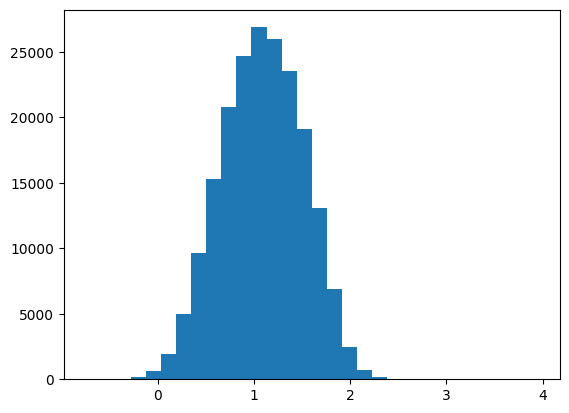

In [18]:
plt.hist(y_pred, bins=30)
plt.show()

In [21]:
(y_pred > 0).sum() / len(y_pred)

0.9964448727051425

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

feature_cols = [col for col in df.columns if col not in ['date', 'target']]
target_col = 'target'

features = df[feature_cols].values
target = df[target_col].values.reshape(-1, 1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()
features_scaled = scaler_X.fit_transform(features)
target_scaled = scaler_y.fit_transform(target)

def create_sequences(features, target, seq_length=1):
    X, y = [], []
    for i in range(len(features) - seq_length):
        X.append(features[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

# Generate the sequences
X, y = create_sequences(features_scaled, target_scaled, seq_length=1)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

num_features = X_train.shape[2]

model = Sequential()
model.add(LSTM(units=50, input_shape=(seq_length, num_features), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

# -----------------------------
# 6. Train the model
# -----------------------------
# Define callbacks for early stopping and saving the best model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("lstm_model_best.h5", monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=256, 
                    validation_split=0.1, 
                    callbacks=[early_stop, checkpoint],
                    verbose=1)

# -----------------------------
# 7. Evaluate the model on test set
# -----------------------------
test_loss = model.evaluate(X_test, y_test)
print("Test Loss (MSE):", test_loss)

# To get predictions in the original scale:
predictions_scaled = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions_scaled)

# For comparison, you can invert y_test too:
y_test_inversed = scaler_y.inverse_transform(y_test)

# Optionally, save your model if needed
model.save("lstm_model_final.h5")